# Statistical Screens for Anomaly Detection

**Мета:** Статистичні методи виявлення аномалій як доповнення до rule-based підходу.

**Методи:**
1. Z-score та IQR outliers
2. Benford's Law аналіз
3. Bid spread analysis
4. HHI market concentration
5. Price pattern detection

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

from src.data_loader import load_tenders, load_bids, load_buyers, memory_usage
from src.detectors.statistical import (
    StatisticalDetector, 
    benford_test, 
    hhi_index,
    BENFORD_EXPECTED
)

# ============================================================
# CONFIGURATION
# ============================================================
# YEARS = [2023, 2024]  # Two years for testing
YEARS = [2022, 2023, 2024, 2025]  # Full dataset
# ============================================================

# Create output directories
Path('../results/figures/statistical').mkdir(parents=True, exist_ok=True)

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

RISK_COLORS = {'critical': '#d62728', 'high': '#ff7f0e', 'medium': '#ffbb78', 'low': '#2ca02c'}

print(f"Configuration: YEARS = {YEARS}")

Configuration: YEARS = [2022, 2023, 2024, 2025]


## 1. Завантаження даних

In [2]:
print(f"Loading data for years: {YEARS}...")
tenders = load_tenders(years=YEARS)
bids = load_bids(years=YEARS)

print(f"\nDataset size:")
print(f"  Tenders: {len(tenders):,}")
print(f"  Bids: {len(bids):,}")
print(f"  Memory: {memory_usage(tenders)}")

Loading data for years: [2022, 2023, 2024, 2025]...
Loaded 2022: 2,401,937 records
Loaded 2023: 3,599,565 records
Loaded 2024: 3,437,381 records
Loaded 2025: 3,657,528 records
Loaded bids 2022: 242,209 records
Loaded bids 2023: 488,758 records
Loaded bids 2024: 847,325 records
Loaded bids 2025: 1,064,277 records

Dataset size:
  Tenders: 13,096,411
  Bids: 2,642,569
  Memory: 10.90 GB


## 2. Benford's Law Analysis

**Закон Бенфорда:** перша значуща цифра чисел у природних даних має нерівномірний розподіл.
Очікувані частоти: 1 (30.1%), 2 (17.6%), 3 (12.5%), ... 9 (4.6%)

**Підхід:**
- **Global** - для візуалізації загального розподілу (весь датасет)
- **Per Buyer** - флагування buyers з аномальним розподілом (потребує 30+ ставок)
- **Per Supplier** - флагування suppliers з аномальним розподілом (потребує 30+ ставок)

Тендер флагується якщо його buyer АБО supplier має аномалію в Benford.

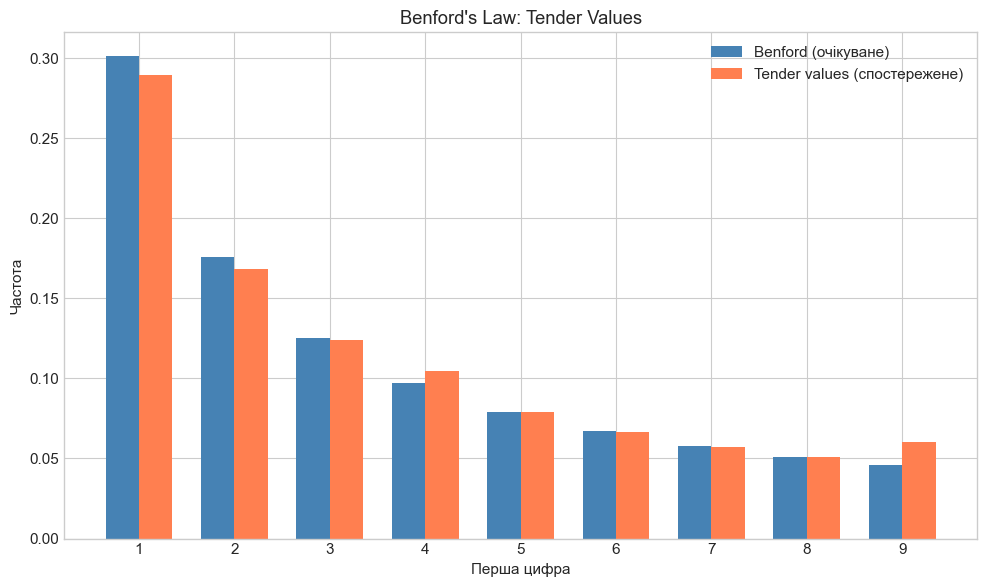


Benford's Law Test:
  Chi-square: 76275.94
  P-value: 0.00e+00
  Anomaly: True


In [3]:
# Extract first digit from tender values
def get_first_digit(x):
    if pd.isna(x) or x <= 0:
        return None
    return int(str(abs(x)).lstrip('0').replace('.', '')[0])

tender_values = tenders[tenders['tender_value'] > 0]['tender_value']
first_digits = tender_values.apply(get_first_digit).dropna().astype(int)

# Observed distribution
observed = first_digits.value_counts(normalize=True).sort_index()

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(1, 10)
width = 0.35

expected_vals = [BENFORD_EXPECTED[d] for d in range(1, 10)]
observed_vals = [observed.get(d, 0) for d in range(1, 10)]

bars1 = ax.bar(x - width/2, expected_vals, width, label='Benford (очікуване)', color='steelblue')
bars2 = ax.bar(x + width/2, observed_vals, width, label='Tender values (спостережене)', color='coral')

ax.set_xlabel('Перша цифра')
ax.set_ylabel('Частота')
ax.set_title('Benford\'s Law: Tender Values')
ax.set_xticks(x)
ax.legend()

plt.tight_layout()
plt.savefig('../results/figures/statistical/benford_tender_values.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistical test
result = benford_test(tender_values)
print(f"\nBenford's Law Test:")
print(f"  Chi-square: {result.statistic:.2f}")
print(f"  P-value: {result.p_value:.2e}")
print(f"  Anomaly: {result.is_anomaly}")

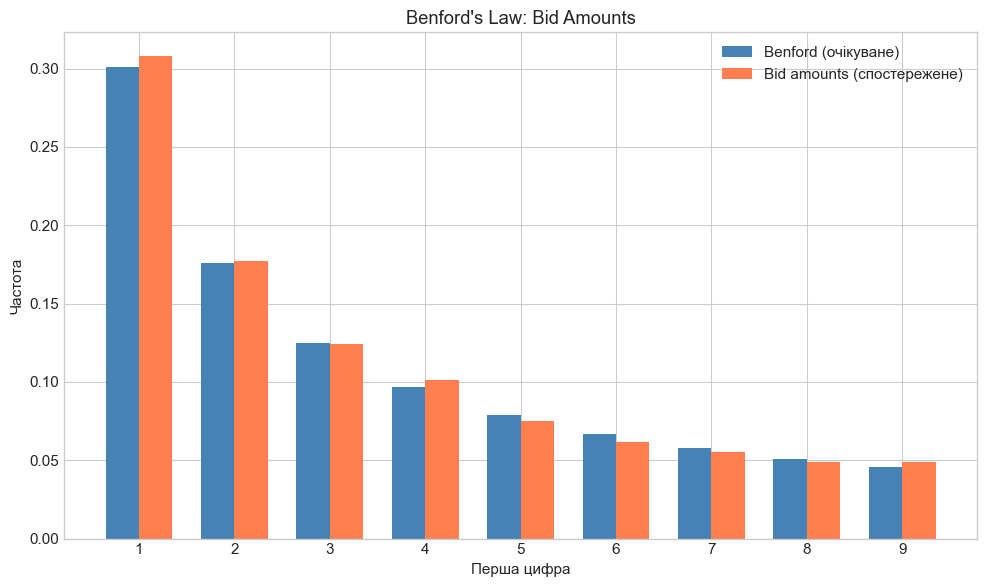


Benford's Law Test (Bids):
  Chi-square: 3593.12
  P-value: 0.00e+00


In [4]:
# Benford for bid amounts
bid_amounts = bids[bids['bid_amount'] > 0]['bid_amount']
bid_first_digits = bid_amounts.apply(get_first_digit).dropna().astype(int)

bid_observed = bid_first_digits.value_counts(normalize=True).sort_index()

fig, ax = plt.subplots(figsize=(10, 6))

bid_observed_vals = [bid_observed.get(d, 0) for d in range(1, 10)]

bars1 = ax.bar(x - width/2, expected_vals, width, label='Benford (очікуване)', color='steelblue')
bars2 = ax.bar(x + width/2, bid_observed_vals, width, label='Bid amounts (спостережене)', color='coral')

ax.set_xlabel('Перша цифра')
ax.set_ylabel('Частота')
ax.set_title('Benford\'s Law: Bid Amounts')
ax.set_xticks(x)
ax.legend()

plt.tight_layout()
plt.savefig('../results/figures/statistical/benford_bid_amounts.png', dpi=150, bbox_inches='tight')
plt.show()

result_bids = benford_test(bid_amounts)
print(f"\nBenford's Law Test (Bids):")
print(f"  Chi-square: {result_bids.statistic:.2f}")
print(f"  P-value: {result_bids.p_value:.2e}")

## 3. Value Distribution Analysis

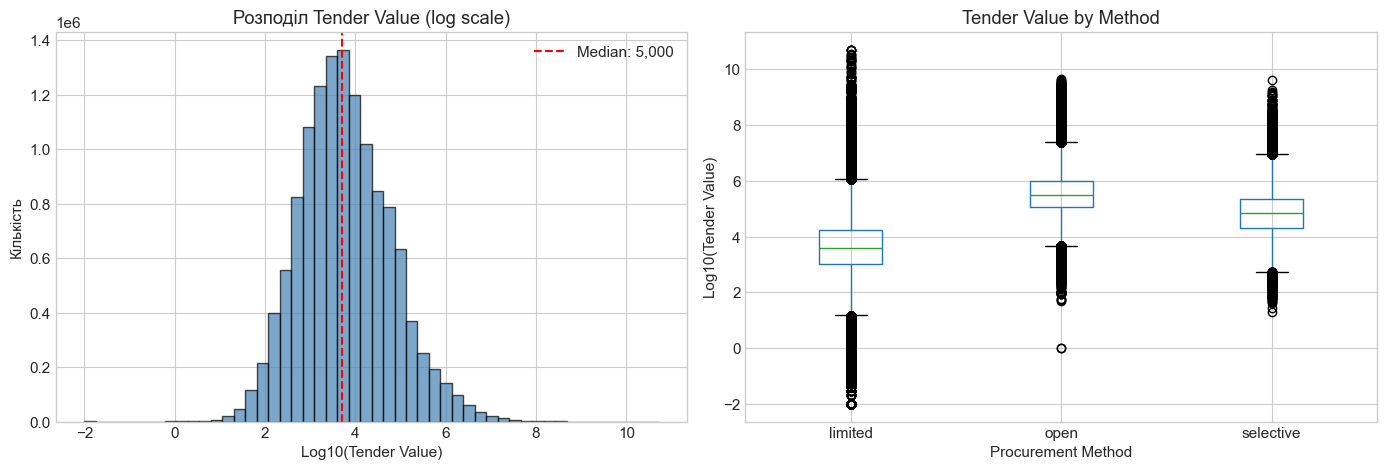

Value statistics:
count    1.288936e+07
mean     2.962858e+05
std      4.064895e+07
min      1.000000e-02
25%      1.200000e+03
50%      5.000000e+03
75%      2.650555e+04
max      5.190000e+10
Name: tender_value, dtype: float64


In [5]:
# Distribution of tender values (log scale)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram (log scale)
values_clean = tenders[tenders['tender_value'] > 0]['tender_value']
axes[0].hist(np.log10(values_clean), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Log10(Tender Value)')
axes[0].set_ylabel('Кількість')
axes[0].set_title('Розподіл Tender Value (log scale)')
axes[0].axvline(np.log10(values_clean.median()), color='red', linestyle='--', label=f'Median: {values_clean.median():,.0f}')
axes[0].legend()

# Box plot by procurement method
data_for_box = tenders[tenders['tender_value'] > 0][['procurement_method', 'tender_value']].copy()
data_for_box['log_value'] = np.log10(data_for_box['tender_value'])
data_for_box.boxplot(column='log_value', by='procurement_method', ax=axes[1])
axes[1].set_xlabel('Procurement Method')
axes[1].set_ylabel('Log10(Tender Value)')
axes[1].set_title('Tender Value by Method')
plt.suptitle('')

plt.tight_layout()
plt.savefig('../results/figures/statistical/value_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Value statistics:")
print(values_clean.describe())

In [6]:
# Z-score outliers
mean_val = values_clean.mean()
std_val = values_clean.std()
zscore = (values_clean - mean_val) / std_val

outliers_3sigma = (zscore.abs() > 3).sum()
outliers_4sigma = (zscore.abs() > 4).sum()

print(f"\nZ-score outliers:")
print(f"  > 3σ: {outliers_3sigma:,} ({outliers_3sigma/len(values_clean)*100:.2f}%)")
print(f"  > 4σ: {outliers_4sigma:,} ({outliers_4sigma/len(values_clean)*100:.2f}%)")

# IQR outliers
q1 = values_clean.quantile(0.25)
q3 = values_clean.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

iqr_outliers = ((values_clean < lower) | (values_clean > upper)).sum()

print(f"\nIQR outliers (1.5x):")
print(f"  Count: {iqr_outliers:,} ({iqr_outliers/len(values_clean)*100:.2f}%)")
print(f"  Lower bound: {lower:,.0f}")
print(f"  Upper bound: {upper:,.0f}")


Z-score outliers:
  > 3σ: 2,706 (0.02%)
  > 4σ: 1,891 (0.01%)

IQR outliers (1.5x):
  Count: 1,967,834 (15.27%)
  Lower bound: -36,758
  Upper bound: 64,464


## 4. Bid Spread Analysis

In [7]:
# Calculate bid spread per tender
bid_stats = bids.groupby('tender_id').agg({
    'bid_amount': ['count', 'min', 'max', 'mean', 'std']
}).reset_index()
bid_stats.columns = ['tender_id', 'bid_count', 'bid_min', 'bid_max', 'bid_mean', 'bid_std']

# Filter tenders with 2+ bids
multi_bid = bid_stats[bid_stats['bid_count'] >= 2].copy()

# Calculate spread and CV
multi_bid['spread'] = multi_bid['bid_max'] / multi_bid['bid_min'].replace(0, np.nan)
multi_bid['cv'] = multi_bid['bid_std'] / multi_bid['bid_mean'].replace(0, np.nan)

print(f"Tenders with 2+ bids: {len(multi_bid):,}")
print(f"\nBid spread statistics:")
print(multi_bid['spread'].describe())

Tenders with 2+ bids: 566,767

Bid spread statistics:
count    5.667670e+05
mean     4.661276e+02
std      1.006284e+05
min      1.000000e+00
25%      1.030563e+00
50%      1.112390e+00
75%      1.279401e+00
max      4.331320e+07
Name: spread, dtype: float64


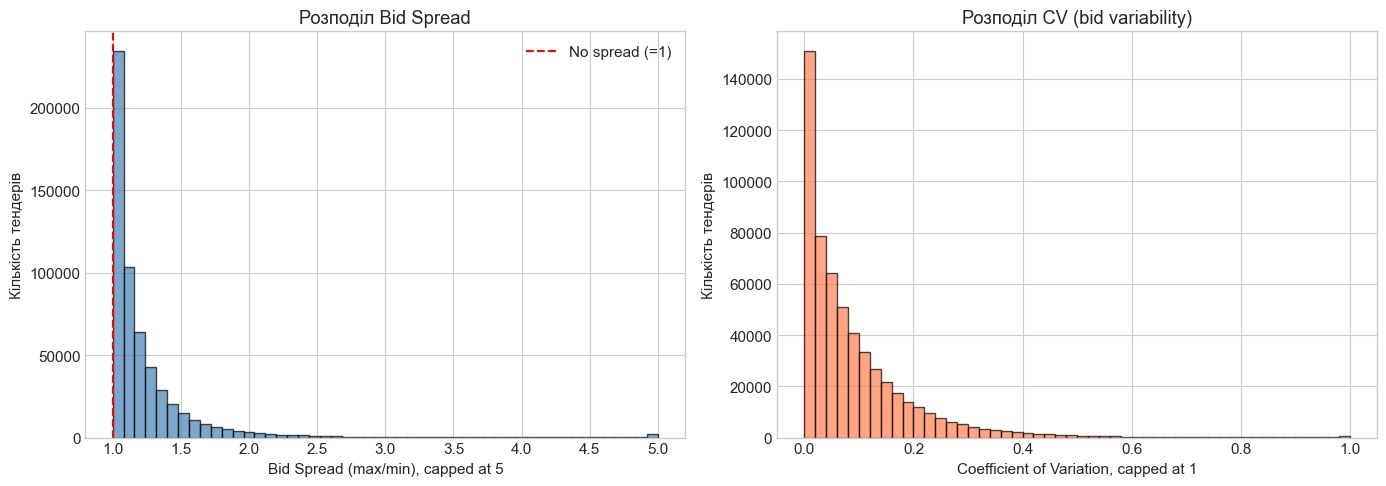


Suspicious bid patterns:
  Identical bids (spread=1): 3,222 (0.57%)
  Very close (<1%): 87,985 (15.52%)
  Very spread (>10x): 1,022 (0.18%)


In [8]:
# Plot bid spread distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Spread histogram (capped at 5 for visibility)
spread_capped = multi_bid['spread'].clip(upper=5)
axes[0].hist(spread_capped, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Bid Spread (max/min), capped at 5')
axes[0].set_ylabel('Кількість тендерів')
axes[0].set_title('Розподіл Bid Spread')
axes[0].axvline(1.0, color='red', linestyle='--', label='No spread (=1)')
axes[0].legend()

# CV histogram
cv_capped = multi_bid['cv'].clip(upper=1)
axes[1].hist(cv_capped.dropna(), bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Coefficient of Variation, capped at 1')
axes[1].set_ylabel('Кількість тендерів')
axes[1].set_title('Розподіл CV (bid variability)')

plt.tight_layout()
plt.savefig('../results/figures/statistical/bid_spread.png', dpi=150, bbox_inches='tight')
plt.show()

# Suspicious patterns
identical_bids = (multi_bid['spread'] == 1).sum()
very_close = (multi_bid['spread'] < 1.01).sum()
very_spread = (multi_bid['spread'] > 10).sum()

print(f"\nSuspicious bid patterns:")
print(f"  Identical bids (spread=1): {identical_bids:,} ({identical_bids/len(multi_bid)*100:.2f}%)")
print(f"  Very close (<1%): {very_close:,} ({very_close/len(multi_bid)*100:.2f}%)")
print(f"  Very spread (>10x): {very_spread:,} ({very_spread/len(multi_bid)*100:.2f}%)")

## 5. Market Concentration (HHI)

In [9]:
# Calculate HHI per buyer
buyer_supplier = tenders.groupby(['buyer_id', 'supplier_id']).agg({
    'tender_value': 'sum'
}).reset_index()

# Market share per buyer
buyer_total = buyer_supplier.groupby('buyer_id')['tender_value'].transform('sum')
buyer_supplier['share'] = buyer_supplier['tender_value'] / buyer_total.replace(0, np.nan)

# HHI
buyer_hhi = buyer_supplier.groupby('buyer_id').apply(
    lambda x: (x['share'] ** 2).sum(), include_groups=False
).reset_index()
buyer_hhi.columns = ['buyer_id', 'hhi']

print(f"Buyers analyzed: {len(buyer_hhi):,}")
print(f"\nHHI distribution:")
print(buyer_hhi['hhi'].describe())

Buyers analyzed: 36,004

HHI distribution:
count    36004.000000
mean         0.273273
std          0.264289
min          0.000000
25%          0.092313
50%          0.171715
75%          0.345259
max          1.000000
Name: hhi, dtype: float64


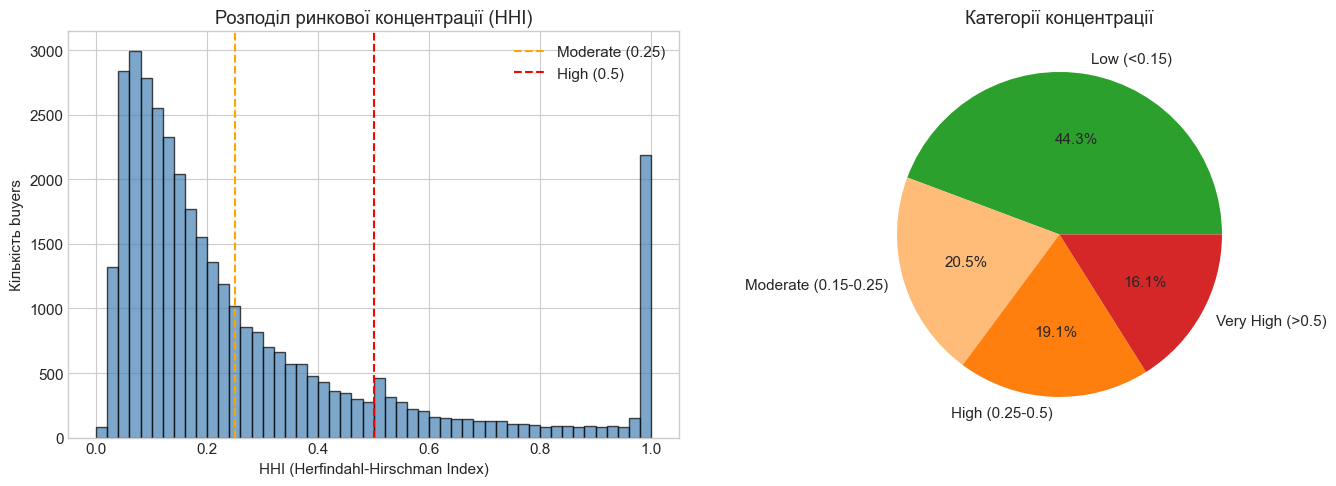


HHI Categories:
  Low (<0.15): 15,948 (44.3%)
  Moderate (0.15-0.25): 7,394 (20.5%)
  High (0.25-0.5): 6,875 (19.1%)
  Very High (>0.5): 5,781 (16.1%)


In [10]:
# HHI distribution plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(buyer_hhi['hhi'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('HHI (Herfindahl-Hirschman Index)')
axes[0].set_ylabel('Кількість buyers')
axes[0].set_title('Розподіл ринкової концентрації (HHI)')
axes[0].axvline(0.25, color='orange', linestyle='--', label='Moderate (0.25)')
axes[0].axvline(0.5, color='red', linestyle='--', label='High (0.5)')
axes[0].legend()

# Categories
hhi_categories = pd.cut(
    buyer_hhi['hhi'],
    bins=[0, 0.15, 0.25, 0.5, 1.01],
    labels=['Low (<0.15)', 'Moderate (0.15-0.25)', 'High (0.25-0.5)', 'Very High (>0.5)']
)
cat_counts = hhi_categories.value_counts()
colors = ['#2ca02c', '#ffbb78', '#ff7f0e', '#d62728']
axes[1].pie(cat_counts, labels=cat_counts.index, colors=colors, autopct='%1.1f%%')
axes[1].set_title('Категорії концентрації')

plt.tight_layout()
plt.savefig('../results/figures/statistical/hhi_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nHHI Categories:")
for cat, count in cat_counts.items():
    print(f"  {cat}: {count:,} ({count/len(buyer_hhi)*100:.1f}%)")

## 6. Run Statistical Detector

In [11]:
# Initialize and run statistical detector
detector = StatisticalDetector(
    zscore_threshold=3.0,
    iqr_multiplier=1.5,
    benford_alpha=0.05
)

results = detector.detect(tenders, bids_df=bids, group_by_cpv=True)

print(f"\nResults: {len(results):,} tenders processed")

Processing 13,096,411 tenders...
Step 1/5: Computing value outliers (Z-score, IQR)...
Step 2/5: Analyzing price patterns...
Step 3/5: Running Benford's Law analysis...
    Testing Benford per buyer...
    Buyers tested: 22,337, anomalies: 7,641
    Testing Benford per supplier...
    Suppliers tested: 72,239, anomalies: 1,992
Step 4/5: Analyzing bid spreads...
Step 5/5: Computing market concentration...
Statistical screening complete!

Results: 13,096,411 tenders processed


In [12]:
# Summary of statistical flags
summary = detector.summary()
print("Statistical flags summary:")
print(summary.to_string(index=False))

Statistical flags summary:
                  flag   count  percentage
         benford_buyer 6818658       52.07
             iqr_value 1967834       15.03
         iqr_value_cpv 1867234       14.26
           round_price 1447633       11.05
      benford_supplier  379313        2.90
    high_concentration  253263        1.93
             99_ending  130269        0.99
      very_round_price   77977        0.60
      zscore_value_cpv   18820        0.14
        bid_clustering   17571        0.13
              monopoly   17562        0.13
award_ratio_suspicious   16470        0.13
    bid_spread_anomaly    8974        0.07
          zscore_value    2706        0.02
       bid_spread_high     821        0.01
       zscore_discount       5        0.00
          iqr_discount       0        0.00


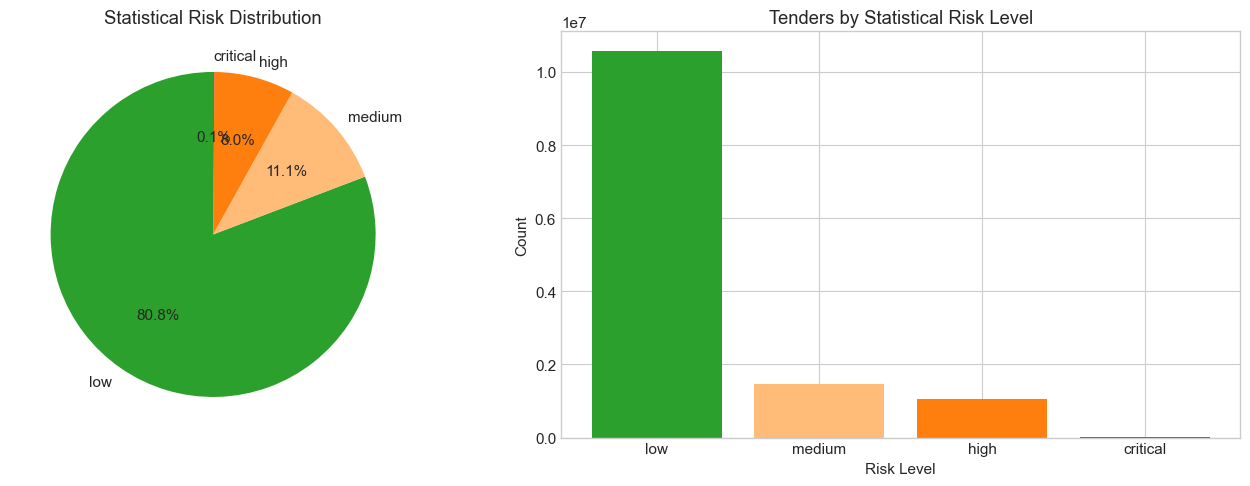

risk_level    count  percentage
       low 10580586       80.79
    medium  1456899       11.12
      high  1042225        7.96
  critical    16701        0.13


In [13]:
# Risk distribution
risk_dist = detector.risk_distribution()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = [RISK_COLORS.get(str(r), 'gray') for r in risk_dist['risk_level']]
axes[0].pie(risk_dist['count'], labels=risk_dist['risk_level'], colors=colors,
            autopct='%1.1f%%', startangle=90)
axes[0].set_title('Statistical Risk Distribution')

# Bar chart
bars = axes[1].bar(risk_dist['risk_level'].astype(str), risk_dist['count'], color=colors)
axes[1].set_xlabel('Risk Level')
axes[1].set_ylabel('Count')
axes[1].set_title('Tenders by Statistical Risk Level')

plt.tight_layout()
plt.savefig('../results/figures/statistical/risk_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(risk_dist.to_string(index=False))

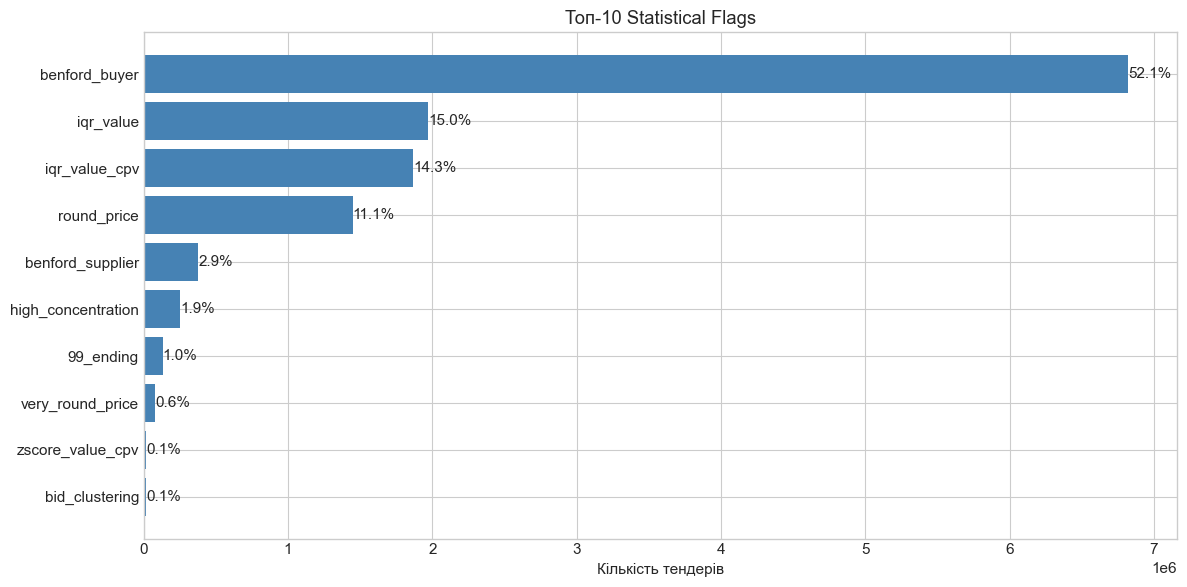

In [14]:
# Top statistical flags
fig, ax = plt.subplots(figsize=(12, 6))

top_flags = summary.head(10)
ax.barh(range(len(top_flags)), top_flags['count'], color='steelblue')
ax.set_yticks(range(len(top_flags)))
ax.set_yticklabels(top_flags['flag'])
ax.invert_yaxis()
ax.set_xlabel('Кількість тендерів')
ax.set_title('Топ-10 Statistical Flags')

# Add percentage labels
for i, (count, pct) in enumerate(zip(top_flags['count'], top_flags['percentage'])):
    ax.text(count + 1000, i, f'{pct:.1f}%', va='center')

plt.tight_layout()
plt.savefig('../results/figures/statistical/top_flags.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Score Distribution

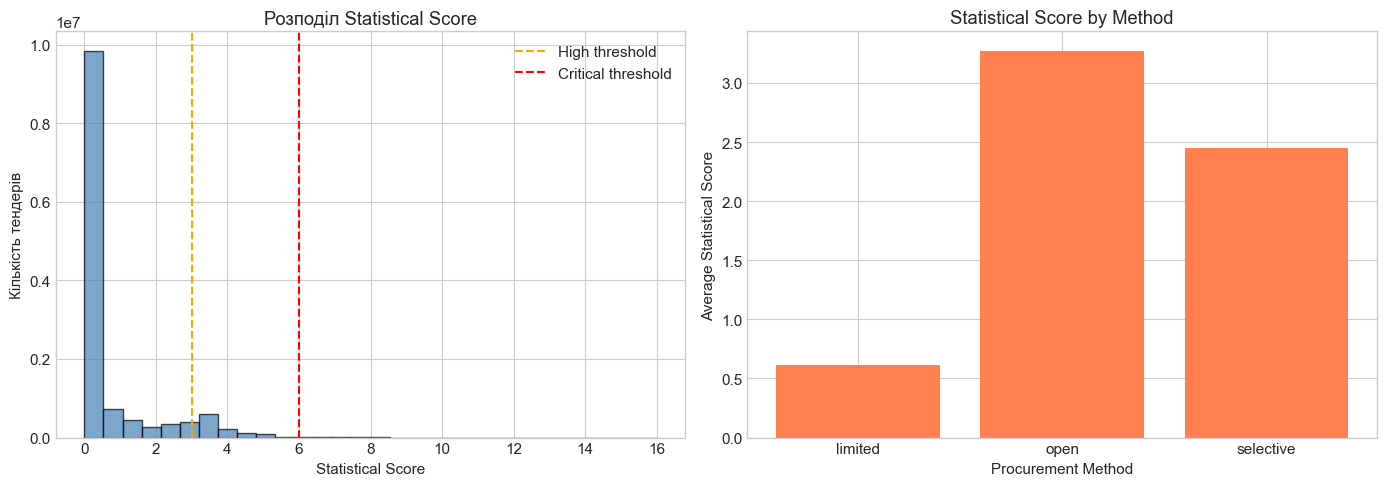


Score statistics:
count    1.309641e+07
mean     8.213694e-01
std      1.175403e+00
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e-01
75%      5.000000e-01
max      1.600000e+01
Name: stat_score, dtype: float64


In [15]:
# Statistical score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(results['stat_score'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Statistical Score')
axes[0].set_ylabel('Кількість тендерів')
axes[0].set_title('Розподіл Statistical Score')
axes[0].axvline(3, color='orange', linestyle='--', label='High threshold')
axes[0].axvline(6, color='red', linestyle='--', label='Critical threshold')
axes[0].legend()

# By procurement method
score_by_method = results.groupby('procurement_method', observed=True)['stat_score'].mean()
axes[1].bar(score_by_method.index, score_by_method.values, color='coral')
axes[1].set_xlabel('Procurement Method')
axes[1].set_ylabel('Average Statistical Score')
axes[1].set_title('Statistical Score by Method')

plt.tight_layout()
plt.savefig('../results/figures/statistical/score_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nScore statistics:")
print(results['stat_score'].describe())

## 8. Comparison with Rule-Based

In [ ]:
# Load rule-based results if available
from src.detectors.rule_based import RuleBasedDetector

print("Running rule-based detector for comparison...")
rule_detector = RuleBasedDetector()
buyers = load_buyers()
rule_results = rule_detector.detect(tenders, buyers_df=buyers, bids_df=bids)

# Merge results
comparison = pd.DataFrame({
    'tender_id': results['tender_id'],
    'stat_score': results['stat_score'],
    'stat_risk': results['stat_risk_level'],
    'rule_score': rule_results['rule_risk_score'],
    'rule_risk': rule_results['rule_risk_level']
})

print(f"\nComparison data: {len(comparison):,} tenders")

Running rule-based detector for comparison...
Loaded buyers: 36,004
Processing 13,096,411 tenders...
Step 1/4: Computing aggregations...
  Computing CPV stats...
  Computing buyer stats...
  Computing supplier stats...
  Computing pair stats...
  Aggregations complete.
Step 2/4: Merging reference data...
Step 3/4: Applying 44 rules...


In [ ]:
# Correlation between scores
correlation = comparison['stat_score'].corr(comparison['rule_score'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot (sample for visibility)
sample = comparison.sample(min(10000, len(comparison)))
axes[0].scatter(sample['rule_score'], sample['stat_score'], alpha=0.3, s=5)
axes[0].set_xlabel('Rule-Based Score')
axes[0].set_ylabel('Statistical Score')
axes[0].set_title(f'Score Correlation (r={correlation:.3f})')

# Agreement matrix
risk_agreement = pd.crosstab(comparison['rule_risk'], comparison['stat_risk'])
sns.heatmap(risk_agreement, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_xlabel('Statistical Risk')
axes[1].set_ylabel('Rule-Based Risk')
axes[1].set_title('Risk Level Agreement')

plt.tight_layout()
plt.savefig('../results/figures/statistical/comparison_rule_based.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nCorrelation: {correlation:.3f}")

In [ ]:
# High-risk agreement
stat_high = (comparison['stat_score'] >= 3).sum()
rule_high = (comparison['rule_score'] >= 6).sum()
both_high = ((comparison['stat_score'] >= 3) & (comparison['rule_score'] >= 6)).sum()

print(f"\nHigh-Risk Detection:")
print(f"  Statistical high: {stat_high:,} ({stat_high/len(comparison)*100:.2f}%)")
print(f"  Rule-based high: {rule_high:,} ({rule_high/len(comparison)*100:.2f}%)")
print(f"  Both high: {both_high:,} ({both_high/len(comparison)*100:.2f}%)")

if stat_high > 0 and rule_high > 0:
    agreement = both_high / max(stat_high, rule_high)
    print(f"  Agreement rate: {agreement*100:.1f}%")

## 9. Summary

In [ ]:
years_str = f"{min(YEARS)}-{max(YEARS)}" if len(YEARS) > 1 else str(YEARS[0])

print("="*60)
print(f"STATISTICAL SCREENS SUMMARY ({years_str})")
print("="*60)

print(f"\nDataset: {len(results):,} tenders")

print(f"\nStatistical Risk Distribution:")
for _, row in risk_dist.iterrows():
    print(f"  {row['risk_level']:10} {row['count']:>10,} ({row['percentage']:>5.2f}%)")

print(f"\nKey Findings:")
anomalies = detector.get_anomalies(min_score=3.0)
print(f"  Statistical anomalies (score >= 3): {len(anomalies):,} ({len(anomalies)/len(results)*100:.2f}%)")

print(f"\nTop 5 statistical flags:")
for _, row in summary.head(5).iterrows():
    print(f"  {row['flag']}: {row['count']:,} ({row['percentage']:.1f}%)")

print("\n" + "="*60)

## Висновки

### Результати:
1. **Benford's Law** - показує відхилення від природного розподілу
2. **Z-score/IQR** - виявляє екстремальні значення
3. **Bid spread** - ідентифікує підозріло схожі/різні ставки
4. **HHI** - показує концентрацію ринку по buyers

### Порівняння з Rule-Based:
- Різні підходи виявляють різні аномалії
- Комбінація дає більш повну картину
- Agreement rate показує перекриття

### Наступні кроки:
- Isolation Forest для ML-based detection
- Ensemble методи для об'єднання результатів